# Augmentation Methodology
The following describes the methodology used to augment the driver information, given that we are going to collapse the data into a frame with single rows per driver. Since we will be inherently losing information by collapsing all of the rows, we will need to supplement the dataset with new columns.

## Temporal Data
Most of the temporal information will be lost when we collapse the rows, so we will need additional columns that summarize that info:

- Start date (first load)
- End date (most recent load)
- Longevity (how long the driver has been employed, according to this dataset)
- Trip Frequency (standard deviation or some measure of variance between trips)
- Load Delta (some standard measure of how many days between each load)
- Preferred weekday (the mode of the `weekday` column
- Normal weekday (the mean or median of the `weekday` column
- Weekday distribution (are the weekdays consistent?)

## Location Data

- Roaming (does the driver have more than one reported `home_base_city` or `home_base_state`?
- Preferred Trip Distance (Possibly use `interested_in_dryage` and `carrier_trucks` to determine a measure of how far the driver prefers to drive)

## Boolean Features

- Indecision (did this person apply to become a driver more than once?)

---

# Transformation Methodology

## Converting categoricals to boolean

The following columns have only two unique values, which are easily turned into boolean features:

- `dim_carrier_type` (**already implemented** corresponds to "is this a self-owned driver?", **0: Fleet, 1: Owner Operator**)
- `interested_in_drayage` (**already implemented** corresponds to "is this driver willing/able to complete drayage shipments?", **0: not specified, 1: yes**)
- `port_qualified` (**already implemented** corresponds to "is this driver qualified to handle port shipments?", **0: no, 1: yes**)
- `signup_source` (**already implemented** corresponds to "did this driver sign up on a mobile device?", **0: Other, 1: Mobile**)
- `driver_with_twic` (**already implemented** corresponds to "does this driver have TWIC insurance?" **0: no, 1: yes**)

## New boolean columns
- `dim_preferred_lanes` (**already implemented** corresponds to "does this driver have a route preference?" **0: null, 1: any**)
- `approved` (**not implemented yet** use `ts_first_approved` and/or `days_signup_to_approval` to determine if the driver was approved)

## One Hot Encoding Categoricals

The following columns have a limited number of unique categorical values that would work well with one-hot encoding

- `carrier_trucks` (**already implemented** 16 unique arrangements of trucks)
- `weekday` (**already implemented** -- pro: maintain all information for day of week, con: 7 extra columns, most of which will be sparse)
- `dim_preferred_lanes` (**not implemented yet** -- 53 unique values -- pro: this might actually mean something, con: it might mean absolutely nothing and will double the number of columns)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
import datetime
import random
from datetime import date
from pprint import pprint
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import statistics 
from statistics import mode

In [2]:
def convert_strings_to_dates(dataframe):
    frame = dataframe.copy()
    frame.dt = [date.fromisoformat(d) for d in frame.dt]
    frame.most_recent_load_date = [date.fromisoformat(d) for d in frame.most_recent_load_date]
    return frame

In [30]:
def aggregate_rows_by_driver_id(dataframe):
    '''
    Returns a new dataframe indexed by Driver ID using an optimal set of aggregations per column.
    This method will return a dataframe that only contains the columns listed below.
    Note: duplicate columns are inherently pruned (simply by not adding them below), so it is 
        safe to pass in the full dataframe and expect a pruned version in return. 
        Also note that the `id_driver` will now be the index of the dataframe and NOT its own column.
    '''
    minimum = 'min'
    maximum = 'max'
    median = 'median'
    random_mode = lambda x: random.choice(pd.Series.mode(x if isinstance(x, list) else list(x)))
    average = lambda x: pd.Series.mean(x)

    aggregation = {
        'dt': maximum,
        'weekday': random_mode,
        'id_carrier_number': random_mode,
        'dim_carrier_type': random_mode,
        'dim_carrier_company_name': mode,
        'home_base_city': mode,
        'home_base_state': mode,
        'carrier_trucks': mode,
        'num_trucks': maximum,
        'interested_in_drayage': random_mode,
        'port_qualified': random_mode,
        'signup_source': random_mode,
        'ts_signup': maximum,
        'ts_first_approved': minimum,
        'days_signup_to_approval': maximum,
        'driver_with_twic': mode,
        'dim_preferred_lanes': mode,
        'first_load_date': minimum,
#         'most_recent_load_date': maximum,
        'loads': random_mode,
        'marketplace_loads_otr': maximum,
        'marketplace_loads_atlas': maximum,
        'marketplace_loads': maximum,
        'brokerage_loads_otr': maximum,
        'brokerage_loads_atlas': maximum,
        'brokerage_loads': maximum,
#         'total_loads': maximum,
        'label': random_mode
    }

    return dataframe.groupby(['id_driver']).agg(aggregation)

In [4]:
def augment_boolean_columns(dataframe):
    frame = dataframe.copy()
    label_encoder = LabelEncoder()
    
    # Replacement (no new columns needed, just transform strings to 0 or 1)
    frame['interested_in_drayage'] = label_encoder.fit_transform(df2.interested_in_drayage)
    frame['port_qualified'] = label_encoder.fit_transform(df2.port_qualified)
    frame['driver_with_twic'] = label_encoder.fit_transform(df2.driver_with_twic)
    
    # Create new columns with more appropriate names, delete the old columns
    frame['self_owned'] = label_encoder.fit_transform(df2.dim_carrier_type)
    frame['mobile_signup'] = np.logical_xor(label_encoder.fit_transform(df2.signup_source), 1).astype(int)
    frame.drop(columns=['dim_carrier_type', 'signup_source'], inplace=True)
    
    # Create new columns with appropriate names, do not delete old columns
    frame['has_route_preference'] = label_encoder.fit_transform(~frame.dim_preferred_lanes.isnull())
    frame['approved'] = label_encoder.fit_transform(~frame.days_signup_to_approval.isnull() & ~frame.ts_first_approved.isnull())
    
    return frame

In [5]:
def encode_categorical_columns(dataframe):
    frame = dataframe.copy()

    # Encode various truck types
    trucks = pd.get_dummies(frame.carrier_trucks)
    trucks.columns = ['truck-' + c.replace('[', '').replace(']', '').replace('"', '').replace(',', '').replace(' ', '-') for c in trucks.columns]
    
    # Encode the 7 different days of the week
    weekdays = pd.get_dummies(frame.weekday)
    weekdays.columns = [f'prefers-{x}'.lower() for x in weekdays.columns]
    
#     Encode ~53 unique preferred routes (not sure if we want to keep this or not)
#     preferred_lanes = pd.get_dummies(df4.dim_preferred_lanes)
#     preferred_lanes.columns = [f'route-{x}' for x in range(len(preferred_lanes.columns))]
#     preferred_lanes
    
    # Drop the originals since they are no longer needed.
    frame.drop(columns=['carrier_trucks', 'weekday'], inplace=True)
    
    # Concatenate various new frames with the original and return
    result = pd.concat([frame, trucks, weekdays], axis=1)
    return result

In [27]:
def generate_labels(dataframe, loads_percentile, most_recent_percentile):
    label_encoder = LabelEncoder()
    frame = dataframe.copy()
    labels = (dataframe.total_loads >= loads_percentile) & (dataframe.most_recent_load_date >= most_recent_percentile)
    frame['label'] = label_encoder.fit_transform(labels)
    frame.drop(columns=['total_loads', 'most_recent_load_date'], inplace=True)
    return frame

## Load CSV to DataFrame

In [7]:
df = pd.read_csv('training_dataset_V3.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83414 entries, 0 to 83413
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                83414 non-null  int64  
 1   dt                        83414 non-null  object 
 2   weekday                   83414 non-null  object 
 3   year                      83414 non-null  int64  
 4   id_driver                 83414 non-null  int64  
 5   id_carrier_number         83414 non-null  object 
 6   dim_carrier_type          83414 non-null  object 
 7   dim_carrier_company_name  83365 non-null  object 
 8   home_base_city            83369 non-null  object 
 9   home_base_state           83369 non-null  object 
 10  carrier_trucks            83414 non-null  object 
 11  num_trucks                83344 non-null  float64
 12  interested_in_drayage     83414 non-null  object 
 13  port_qualified            83414 non-null  object 
 14  signup

**Verify that no columns are duplicates**

In [8]:
for (columnName1, columnData1) in df.iteritems():
    for (columnName2, columnData2) in df.iteritems():
        if columnData1.equals(columnData2) and columnName1 is not columnName2:
            print(f'{columnName1} is equal to {columnName2}')

dt is equal to load_day
load_day is equal to dt


**Drops duplicates and unwanted columns**

In [9]:
df.drop(columns=['Unnamed: 0', 'load_day'], inplace=True)

**Convert strings to dates for easier processing**

In [10]:
df = convert_strings_to_dates(df)

## Collapse DataFrame into single rows per driver

In [11]:
df2 = df.groupby(['id_driver']).agg('max')

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5291 entries, 20 to 38125
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   dt                        5291 non-null   object 
 1   weekday                   5291 non-null   object 
 2   year                      5291 non-null   int64  
 3   id_carrier_number         5291 non-null   object 
 4   dim_carrier_type          5291 non-null   object 
 5   dim_carrier_company_name  5284 non-null   object 
 6   home_base_city            5279 non-null   object 
 7   home_base_state           5279 non-null   object 
 8   carrier_trucks            5291 non-null   object 
 9   num_trucks                5249 non-null   float64
 10  interested_in_drayage     5291 non-null   object 
 11  port_qualified            5291 non-null   object 
 12  signup_source             5291 non-null   object 
 13  ts_signup                 5291 non-null   object 
 14  ts_fir

# Label Generation - Two Methods

There are (at least) two methods we can use to generate the target labels. One would consider the data *before* it has been collapsed, and the other would consider the data *after* it has been collapsed.

It seems to make sense to collapse the data before taking the 75th percentile of the `total_loads`, because otherwise you will be counting a bunch of drivers many times (as many times as they have rows in the dataset, since `total_loads` is cumulative, and the same value for each row for any given driver) and ignoring others.

In my opinion, using `most_recent_load_date` to determine a high-performance driver doesn't make that much sense, since clearly a driver can perform well and not have delivered a load within the last week or so. If we look at the original dateset, the 75th percentile of `most_recent_load_date` is 2021-02-14, which is just three days before the latest date, 2021-02-17. This means if a person happened to take a few days off, they would not be considered high-performing. However, if we use the *collapsed* dataset, then we're looking at 2020-05-19 as the 75th percentile. This is also problematic because it means that a driver might not have driven for nearly 9 months but would still be considered high-performance.

## 1 - Use the original dataset

The top 75th percentile of total_loads is >= 325.0


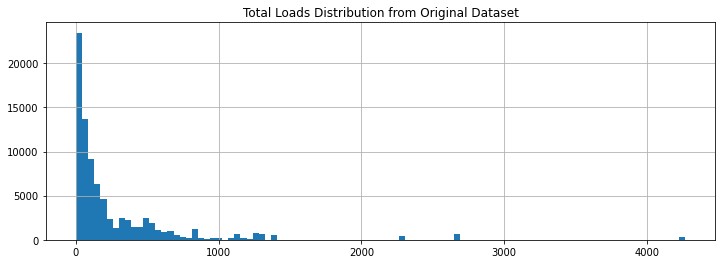

In [13]:
plt.figure(figsize=(12,4))
df.total_loads.hist(bins=100)
plt.title('Total Loads Distribution from Original Dataset')
top_loads = df.total_loads.quantile(0.75)
print(f'The top 75th percentile of total_loads is >= {top_loads}')

The top 75th percentile of most_recent_load_date falls on 2021-02-14


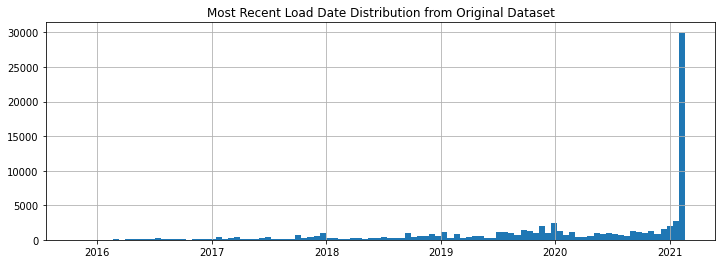

In [14]:
plt.figure(figsize=(12,4))
df.most_recent_load_date.hist(bins=100)
plt.title('Most Recent Load Date Distribution from Original Dataset')
top_most_recent = df.most_recent_load_date.quantile(0.75)
print(f'The top 75th percentile of most_recent_load_date falls on {top_most_recent}')

## 2 - Use the collapsed dataset

The top 75th percentile of total_loads is >= 17.0


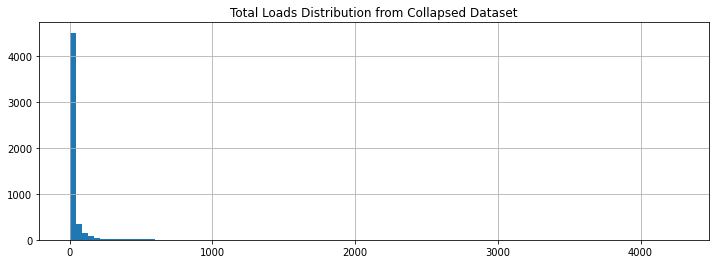

In [15]:
plt.figure(figsize=(12,4))
df2.total_loads.hist(bins=100)
plt.title('Total Loads Distribution from Collapsed Dataset')
top_loads = df2.total_loads.quantile(0.75)
print(f'The top 75th percentile of total_loads is >= {top_loads}')

The top 75th percentile of most_recent_load_date falls on 2020-05-19


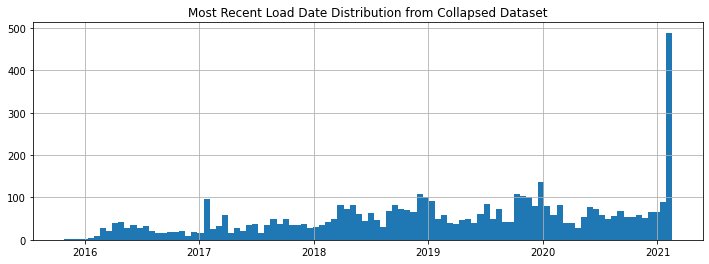

In [16]:
plt.figure(figsize=(12,4))
df2.most_recent_load_date.hist(bins=100)
plt.title('Most Recent Load Date Distribution from Collapsed Dataset')
top_most_recent = df2.most_recent_load_date.quantile(0.75)
print(f'The top 75th percentile of most_recent_load_date falls on {top_most_recent}')

# Let's run some tests...

- Method 1: `total_loads` from original, `most_recent_load_date` from original
- Method 2: `total_loads` from original, `most_recent_load_date` from collapsed
- Method 3: `total_loads` from collapsed, `most_recent_load_date` from original
- Method 4: `total_loads` from collapsed, `most_recent_load_date` from collapsed

In [17]:
df2 = df.groupby('id_driver').agg('max')

In [18]:
top_loads1 = df.total_loads.quantile(0.75)
top_loads2 = df2.total_loads.quantile(0.75)

top_most_recent1 = df.most_recent_load_date.quantile(0.75)
top_most_recent2 = df2.most_recent_load_date.quantile(0.75)

top_loads1, top_loads2, top_most_recent1, top_most_recent2

(325.0, 17.0, datetime.date(2021, 2, 14), datetime.date(2020, 5, 19))

In [19]:
top1 = df[(df.total_loads >= top_loads1) & (df.most_recent_load_date >= top_most_recent1)]
top2 = df[(df.total_loads >= top_loads1) & (df.most_recent_load_date >= top_most_recent2)]
top3 = df[(df.total_loads >= top_loads2) & (df.most_recent_load_date >= top_most_recent1)]
top4 = df[(df.total_loads >= top_loads2) & (df.most_recent_load_date >= top_most_recent2)]

In [20]:
n_datapoints = df.shape[0]
data1, data2, data3, data4 = top1.shape[0], top2.shape[0], top3.shape[0], top4.shape[0]
print(f'{(data1 / n_datapoints) * 100:.2f}% of samples considered high-performance using method 1 ({data1} rows)')
print(f'{(data2 / n_datapoints) * 100:.2f}% of samples considered high-performance using method 2 ({data2} rows)')
print(f'{(data3 / n_datapoints) * 100:.2f}% of samples considered high-performance using method 3 ({data3} rows)')
print(f'{(data4 / n_datapoints) * 100:.2f}% of samples considered high-performance using method 4 ({data4} rows)')

12.46% of samples considered high-performance using method 1 (10393 rows)
19.57% of samples considered high-performance using method 2 (16326 rows)
25.07% of samples considered high-performance using method 3 (20910 rows)
52.10% of samples considered high-performance using method 4 (43460 rows)


In [21]:
rows1 = top1.groupby(['id_driver']).agg('max').shape[0]
rows2 = top2.groupby(['id_driver']).agg('max').shape[0]
rows3 = top3.groupby(['id_driver']).agg('max').shape[0]
rows4 = top4.groupby(['id_driver']).agg('max').shape[0]

In [22]:
n_drivers = df2.shape[0]
print(f'{(rows1 / n_drivers) * 100:.2f}% of drivers considered high-performance using method 1 ({rows1} drivers)')
print(f'{(rows2 / n_drivers) * 100:.2f}% of drivers considered high-performance using method 2 ({rows2} drivers)')
print(f'{(rows3 / n_drivers) * 100:.2f}% of drivers considered high-performance using method 3 ({rows3} drivers)')
print(f'{(rows4 / n_drivers) * 100:.2f}% of drivers considered high-performance using method 4 ({rows4} drivers)')

1.04% of drivers considered high-performance using method 1 (55 drivers)
1.68% of drivers considered high-performance using method 2 (89 drivers)
5.27% of drivers considered high-performance using method 3 (279 drivers)
13.36% of drivers considered high-performance using method 4 (707 drivers)


# Results

- Method 1: Labels 12.5% of the data but only 1.04% of drivers
- Method 2: Labels 19.57% of the data but only 1.68% of drivers
- **Method 3: Labels 25% of the data and 5.27% of drivers**
- Method 4: Labels 52% of the data and 13.36% of drivers

# Generate Labels

In [40]:
labeled_df = generate_labels(df, top_loads2, top_most_recent1)

In [41]:
df3 = aggregate_rows_by_driver_id(labeled_df)

In [42]:
df4 = augment_boolean_columns(df3)

In [43]:
df5 = encode_categorical_columns(df4)

array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'id_driver'}>,
        <AxesSubplot:title={'center':'num_trucks'}>],
       [<AxesSubplot:title={'center':'days_signup_to_approval'}>,
        <AxesSubplot:title={'center':'loads'}>,
        <AxesSubplot:title={'center':'marketplace_loads_otr'}>],
       [<AxesSubplot:title={'center':'marketplace_loads_atlas'}>,
        <AxesSubplot:title={'center':'marketplace_loads'}>,
        <AxesSubplot:title={'center':'brokerage_loads_otr'}>],
       [<AxesSubplot:title={'center':'brokerage_loads_atlas'}>,
        <AxesSubplot:title={'center':'brokerage_loads'}>,
        <AxesSubplot:title={'center':'label'}>]], dtype=object)

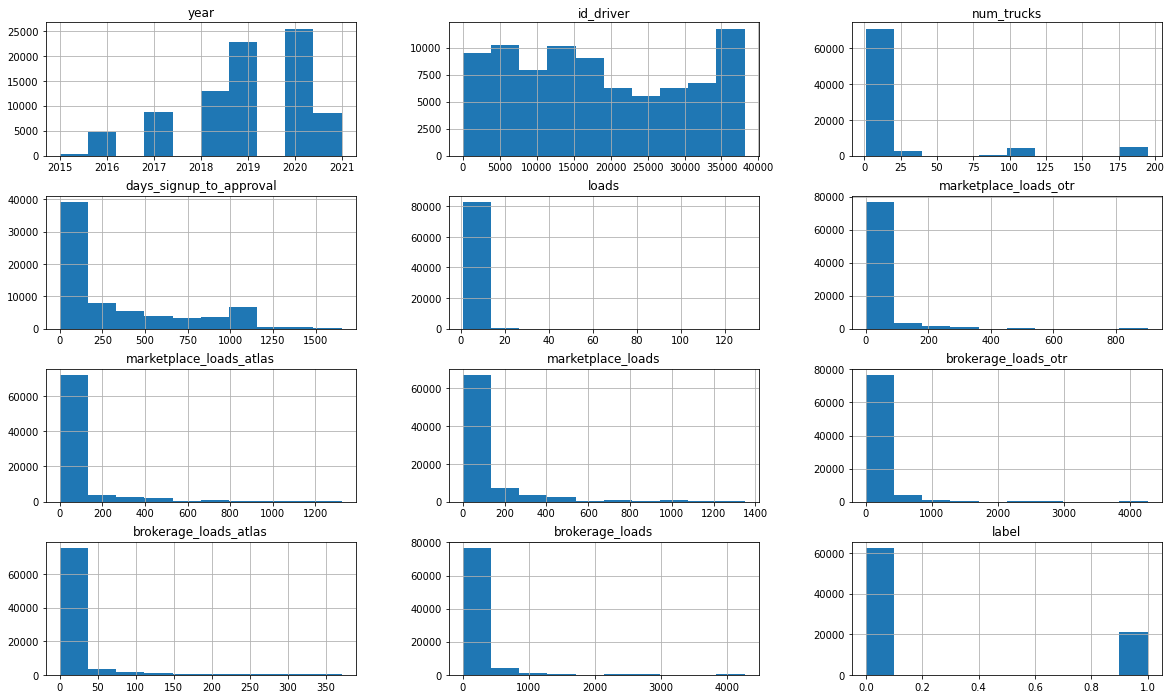

In [47]:
labeled_df.hist(figsize=(20,12))

# 4 - Pipeline

# 5 - Linear Regression

# 6 - PCA

# 7 - Ensemble Method

# 8 - Neural Network

# 9 - Cross Validation

# 10 - Custom Model